In [1]:
# Libraries
from datetime import datetime

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from functions import *

# Warning silencer
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None

In [2]:
train = pd.read_pickle("train.pkl")
test = pd.read_pickle("test.pkl")
train

,Date,StoreCode,ProductCode,SalesQuantity,IsPromoted,ProductGroup1,ProductGroup2
0,2015-01-01,8,9,-1,False,H,15
1,2015-01-01,131,9,1,False,H,15
2,2015-01-01,144,9,2,False,H,15
3,2015-01-01,203,9,2,False,H,15
4,2015-01-01,256,9,0,False,H,15
...,...,...,...,...,...,...,...
1873613,2015-07-30,292,315,0,False,D,16
1873614,2015-07-31,12,315,1,False,D,16
1873615,2015-07-31,104,315,1,False,D,16
1873616,2015-07-31,261,315,1,False,D,16


In [3]:
# List of products
products = list(train["ProductCode"].unique())
products.sort()
stores =  list(train["StoreCode"].unique())
stores.sort()

# Store counts per product & product counts per store
pairs = train[["ProductCode", "StoreCode"]].drop_duplicates()
store_counts = pairs.groupby(["ProductCode"])['StoreCode'].count()
product_counts = pairs.groupby(["StoreCode"])['ProductCode'].count()

store_counts

ProductCode
1      302
2      307
3      312
4      305
5      324
      ... 
313    124
314    279
315    197
316    310
317    273
Name: StoreCode, Length: 317, dtype: int64

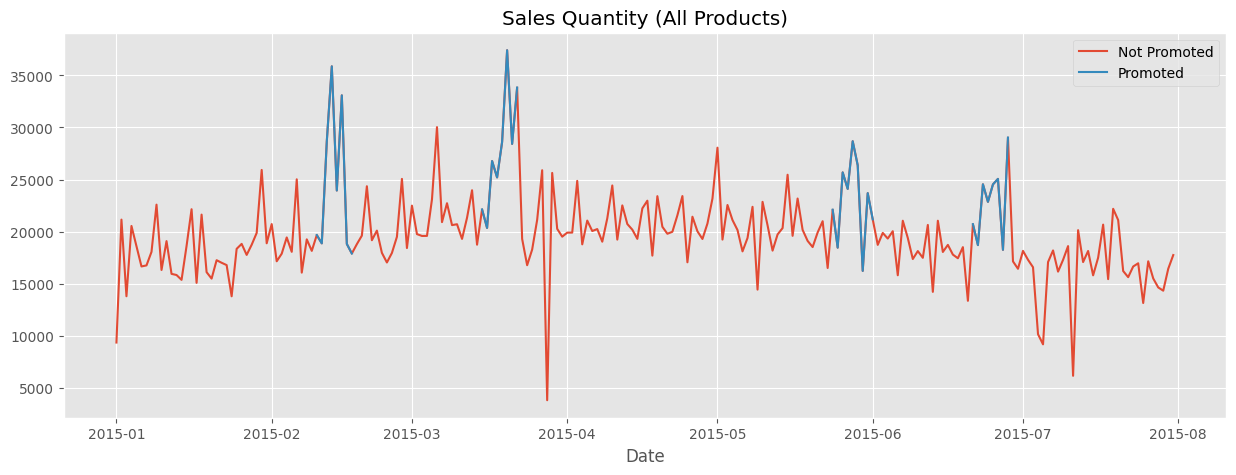

In [4]:
# All products time series plot
plot_promo_time_series(train)

In [5]:
# Daily sales average by product
daily_avg_sales = []
for p in products:
    row = {"ProductCode": p}
    avg_sales = train[train.ProductCode == p].groupby(["IsPromoted"])['SalesQuantity'].mean()
    row.update(round(avg_sales, 2))
    daily_avg_sales.append(row)

daily_avg_sales = pd.DataFrame.from_records(daily_avg_sales).set_index("ProductCode")
daily_avg_sales.columns = ["Nonpromoted", "Promoted"]
daily_avg_sales["Promo Diff."] = daily_avg_sales.Promoted - daily_avg_sales.Nonpromoted
daily_avg_sales["% Change with Promo"] = (daily_avg_sales.Promoted - daily_avg_sales.Nonpromoted)/daily_avg_sales.Nonpromoted*100

daily_avg_sales

,Nonpromoted,Promoted,Promo Diff.,% Change with Promo
ProductCode,,,,
1,2.38,2.42,0.04,1.680672
2,2.20,2.34,0.14,6.363636
3,1.76,2.00,0.24,13.636364
4,2.15,2.18,0.03,1.395349
5,1.98,2.37,0.39,19.696970
...,...,...,...,...
313,2.23,2.38,0.15,6.726457
314,0.58,0.57,-0.01,-1.724138
315,0.44,0.50,0.06,13.636364


### Clusters by Product

In [6]:
# Weekly sales averages
avg_weekly_sales_by_product = generate_avg_weekly_sales(train, by="product", groups=products)

<Axes: ylabel='Frequency'>

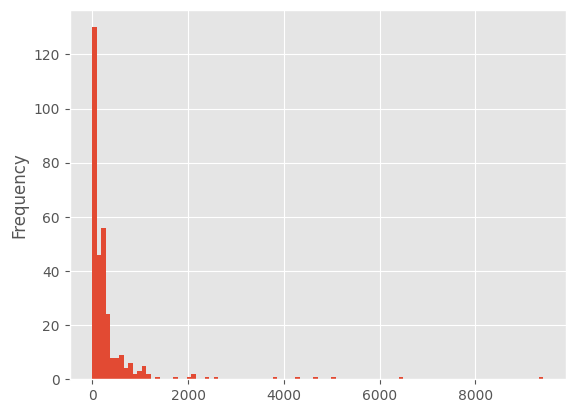

In [7]:
# Average weekly sales histogram
avg_weekly_sales_by_product["Avg. Weekly Sales"].plot.hist(bins = 100)

In [8]:
avg_weekly_sales_by_product = avg_weekly_sales_by_product.join(store_counts)
avg_weekly_sales_by_product.columns = ['Avg. Weekly Sales', 'Store Count']
avg_weekly_sales_by_product["Sales-Stores Ratio"] = avg_weekly_sales_by_product["Avg. Weekly Sales"] / avg_weekly_sales_by_product["Store Count"]
avg_weekly_sales_by_product

,Avg. Weekly Sales,Store Count,Sales-Stores Ratio
1,304.354839,302,1.007797
2,229.483871,307,0.747504
3,166.870968,312,0.534843
4,203.870968,305,0.668429
5,246.032258,324,0.759359
...,...,...,...
313,337.222222,124,2.719534
314,21.645161,279,0.077581
315,14.903226,197,0.075651
316,31.419355,310,0.101353


       Sales-Stores Ratio
count          316.000000
mean             1.045104
std              2.564277
min             -2.000000
25%              0.085839
50%              0.484355
75%              0.894690
max             27.848826


<Axes: >

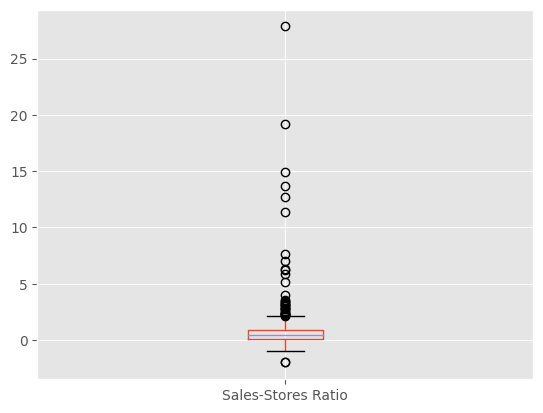

In [9]:
d1 = pd.DataFrame(avg_weekly_sales_by_product["Sales-Stores Ratio"]).dropna()
print(d1.describe())
d1.boxplot()

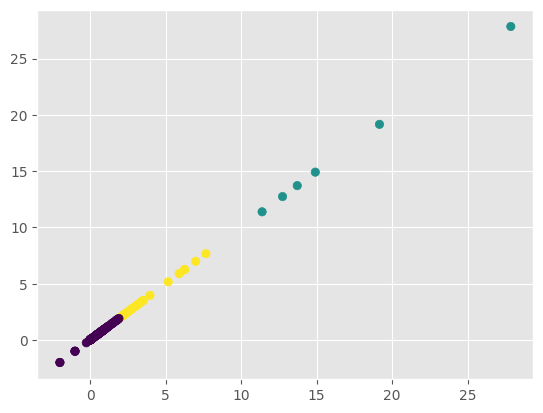

In [10]:
# Clustering weekly sales

kmeans_by_product = KMeans(n_clusters=3, n_init=10, random_state=1)
kmeans_by_product.fit(d1)
d1["Label"] = kmeans_by_product.labels_

plt.scatter(d1["Sales-Stores Ratio"], d1["Sales-Stores Ratio"], c=kmeans_by_product.labels_)
plt.show() 

In [11]:
display_clustering_stats(d1, kmeans_by_product)

            0      1      2
count  279.00   6.00  31.00
mean     0.44  16.63   3.43
std      0.52   6.10   1.58
min     -2.00  11.39   1.98
25%      0.07  12.98   2.31
50%      0.42  14.31   2.86
75%      0.75  18.09   3.51
max      1.91  27.85   7.67


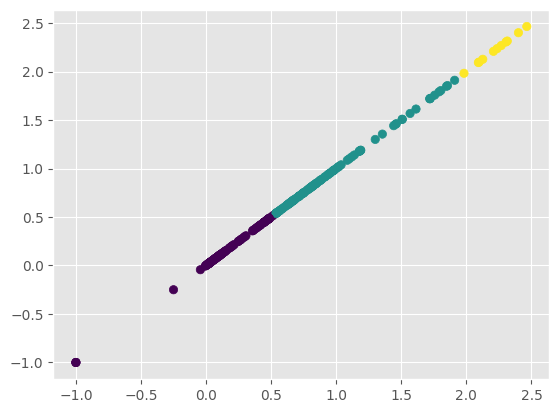

In [12]:
lower_b = -1
upper_b = 2.5
d2 = d1[(d1["Sales-Stores Ratio"] <= upper_b) & (d1["Sales-Stores Ratio"] >= lower_b)]

kmeans_by_product = KMeans(n_clusters=3, n_init=10, random_state=1)
kmeans_by_product.fit(d2)
d2["Label"] = kmeans_by_product.labels_

plt.scatter(d2["Sales-Stores Ratio"], d2["Sales-Stores Ratio"], c=kmeans_by_product.labels_)
plt.show() 

In [13]:
display_clustering_stats(d2, kmeans_by_product)

            0       1      2
count  160.00  117.00  11.00
mean     0.13    0.91   2.23
std      0.23    0.35   0.14
min     -1.00    0.53   1.98
25%      0.03    0.67   2.11
50%      0.09    0.81   2.24
75%      0.21    1.02   2.31
max      0.51    1.91   2.46


In [14]:
labels_dict = {0:"Slow", 2:"Fast", 1:"Medium"}
d1_to_append_fast = d1[d1["Sales-Stores Ratio"] > upper_b]
d1_to_append_fast["Label"] = 2
d1_to_append_slow = d1[d1["Sales-Stores Ratio"] < lower_b]
d1_to_append_slow["Label"] = 0

clusters_by_product = pd.concat([d2, d1_to_append_fast, d1_to_append_slow]).replace({"Label": labels_dict})
clusters_by_product

,Sales-Stores Ratio,Label
1,1.007797,Medium
2,0.747504,Medium
3,0.534843,Medium
4,0.668429,Medium
5,0.759359,Medium
...,...,...
222,5.167799,Fast
238,3.371115,Fast
313,2.719534,Fast
226,-2.000000,Slow


In [15]:
# Checking for missing products
for product in [x for x in products if x not in list(clusters_by_product.index)]:
    print(train[train["ProductCode"]==product])

              Date  StoreCode  ProductCode  SalesQuantity  IsPromoted   
1182790 2015-02-16          3          261              0        True  \

        ProductGroup1  ProductGroup2  
1182790             F             27  


<Axes: title={'center': 'Sales-Stores Ratio'}, xlabel='[Label]'>

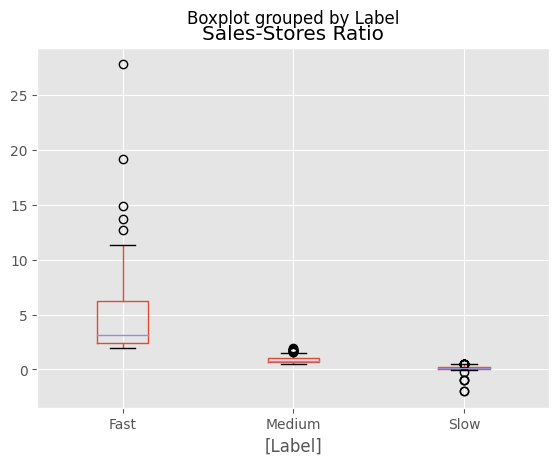

In [16]:
clusters_by_product.boxplot(by="Label")

### Clusters by Store

In [17]:
avg_weekly_sales_by_store = generate_avg_weekly_sales(train, by="store", groups=stores)

<Axes: ylabel='Frequency'>

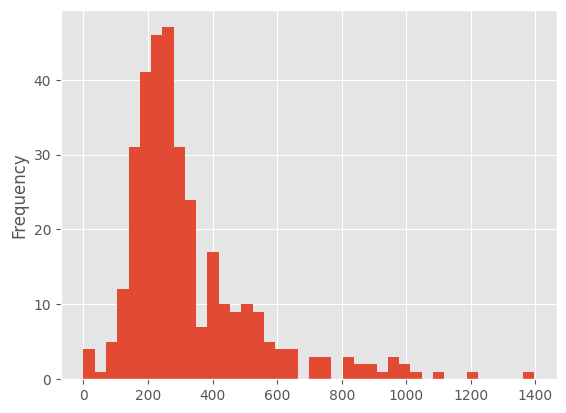

In [18]:
avg_weekly_sales_by_store["Avg. Weekly Sales"].plot.hist(bins = 40)

In [19]:
avg_weekly_sales_by_store = avg_weekly_sales_by_store.join(product_counts)
avg_weekly_sales_by_store.columns = ['Avg. Weekly Sales', 'Product Count']
avg_weekly_sales_by_store["Sales-Products Ratio"] = avg_weekly_sales_by_store["Avg. Weekly Sales"] / avg_weekly_sales_by_store["Product Count"]
avg_weekly_sales_by_store

,Avg. Weekly Sales,Product Count,Sales-Products Ratio
1,334.645161,255,1.312334
2,1089.225806,262,4.157350
3,218.806452,240,0.911694
4,337.387097,260,1.297643
5,274.483871,271,1.012856
...,...,...,...
336,285.032258,247,1.153977
337,369.580645,255,1.449336
338,310.741935,252,1.233103
339,434.161290,245,1.772087


       Sales-Products Ratio
count            340.000000
mean               1.307233
std                0.777977
min                0.000000
25%                0.835576
50%                1.073115
75%                1.560673
max                5.289712


<Axes: >

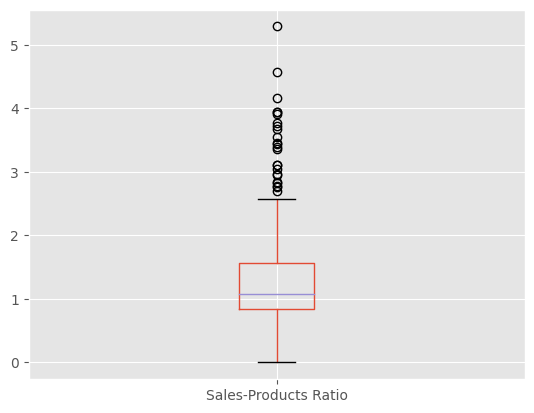

In [20]:
clusters_by_store = pd.DataFrame(avg_weekly_sales_by_store["Sales-Products Ratio"]).dropna()
print(clusters_by_store.describe())
clusters_by_store.boxplot()

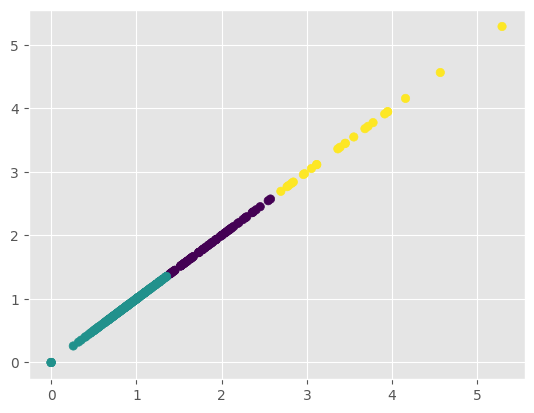

In [21]:
kmeans_by_store = KMeans(n_clusters=3, n_init=10)
kmeans_by_store.fit(clusters_by_store)
clusters_by_store["Label"] = kmeans_by_store.labels_

plt.scatter(clusters_by_store["Sales-Products Ratio"], clusters_by_store["Sales-Products Ratio"], c=kmeans_by_store.labels_)
plt.show() 

In [22]:
display_clustering_stats(clusters_by_store, kmeans_by_store)

           0       1      2
count  77.00  239.00  24.00
mean    1.85    0.91   3.47
std     0.31    0.26   0.63
min     1.39    0.00   2.69
25%     1.59    0.76   2.97
50%     1.81    0.93   3.42
75%     2.08    1.10   3.81
max     2.57    1.36   5.29


In [23]:
labels_dict = {2:"Fast", 0:"Medium", 1:"Slow"}
clusters_by_store = clusters_by_store.replace({"Label": labels_dict})
clusters_by_store

,Sales-Products Ratio,Label
1,1.312334,Slow
2,4.157350,Fast
3,0.911694,Slow
4,1.297643,Slow
5,1.012856,Slow
...,...,...
336,1.153977,Slow
337,1.449336,Medium
338,1.233103,Slow
339,1.772087,Medium


<Axes: title={'center': 'Sales-Products Ratio'}, xlabel='[Label]'>

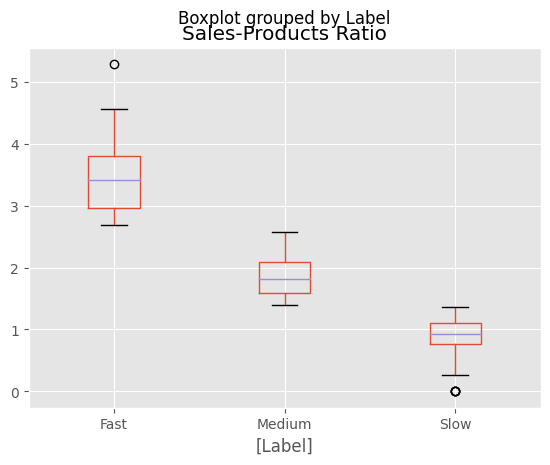

In [24]:
clusters_by_store.boxplot(by="Label")

### Part C

In [25]:
promo_effect_by_product = daily_avg_sales.join(clusters_by_product)
promo_effect_by_product

,Nonpromoted,Promoted,Promo Diff.,% Change with Promo,Sales-Stores Ratio,Label
ProductCode,,,,,,
1,2.38,2.42,0.04,1.680672,1.007797,Medium
2,2.20,2.34,0.14,6.363636,0.747504,Medium
3,1.76,2.00,0.24,13.636364,0.534843,Medium
4,2.15,2.18,0.03,1.395349,0.668429,Medium
5,1.98,2.37,0.39,19.696970,0.759359,Medium
...,...,...,...,...,...,...
313,2.23,2.38,0.15,6.726457,2.719534,Fast
314,0.58,0.57,-0.01,-1.724138,0.077581,Slow
315,0.44,0.50,0.06,13.636364,0.075651,Slow


In [26]:
# Top 5 Promotion Boosts by Product
promo_effect_by_product.sort_values(by=['% Change with Promo'], ascending=False).head()

,Nonpromoted,Promoted,Promo Diff.,% Change with Promo,Sales-Stores Ratio,Label
ProductCode,,,,,,
231,0.25,0.91,0.66,264.0,0.016393,Slow
192,0.16,0.50,0.34,212.5,0.008489,Slow
55,0.11,0.33,0.22,200.0,0.004260,Slow
291,0.50,1.50,1.00,200.0,0.020000,Slow
22,0.25,0.69,0.44,176.0,0.029519,Slow


In [27]:
# Average Promotion Effects by Product Clusters
promo_effect_by_product.groupby(["Label"])[["Promo Diff.", "% Change with Promo"]].mean()

,Promo Diff.,% Change with Promo
Label,,
Fast,0.908919,23.516395
Medium,0.176810,10.885806
Slow,0.128231,13.116219


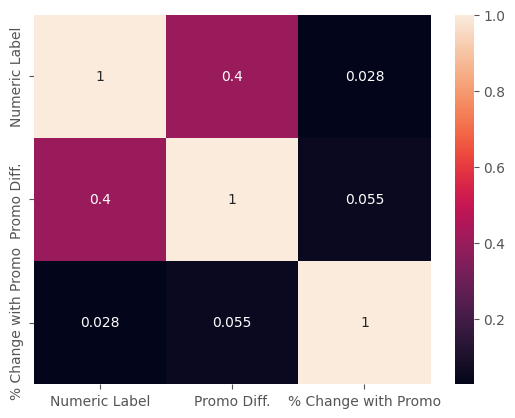

In [28]:
numeric_labels = {"Slow": 0, "Medium": 1, "Fast": 2}
promo_effect_by_product['Numeric Label'] = promo_effect_by_product['Label'].map(numeric_labels)
# plotting correlation heatmap 
dataplot = sns.heatmap(promo_effect_by_product[["Numeric Label", "Promo Diff.", "% Change with Promo"]].corr(), annot=True) 
plt.show() 

### Part D

In [29]:
promo_effect_by_store = daily_avg_sales.join(clusters_by_store)
promo_effect_by_store

,Nonpromoted,Promoted,Promo Diff.,% Change with Promo,Sales-Products Ratio,Label
ProductCode,,,,,,
1,2.38,2.42,0.04,1.680672,1.312334,Slow
2,2.20,2.34,0.14,6.363636,4.157350,Fast
3,1.76,2.00,0.24,13.636364,0.911694,Slow
4,2.15,2.18,0.03,1.395349,1.297643,Slow
5,1.98,2.37,0.39,19.696970,1.012856,Slow
...,...,...,...,...,...,...
313,2.23,2.38,0.15,6.726457,1.225545,Slow
314,0.58,0.57,-0.01,-1.724138,1.660631,Medium
315,0.44,0.50,0.06,13.636364,0.947191,Slow


In [30]:
# Top 5 Promotion Boosts by Store
promo_effect_by_store.sort_values(by=['% Change with Promo'], ascending=False).head()

,Nonpromoted,Promoted,Promo Diff.,% Change with Promo,Sales-Products Ratio,Label
ProductCode,,,,,,
231,0.25,0.91,0.66,264.0,0.951278,Slow
192,0.16,0.50,0.34,212.5,0.781007,Slow
55,0.11,0.33,0.22,200.0,2.088493,Medium
291,0.50,1.50,1.00,200.0,1.525202,Medium
22,0.25,0.69,0.44,176.0,2.203392,Medium


In [31]:
# Average Promotion Effects by Store Clusters
promo_effect_by_store.groupby(["Label"])[["Promo Diff.", "% Change with Promo"]].mean()

,Promo Diff.,% Change with Promo
Label,,
Fast,0.275714,16.432925
Medium,0.287429,21.641433
Slow,0.225263,10.530873


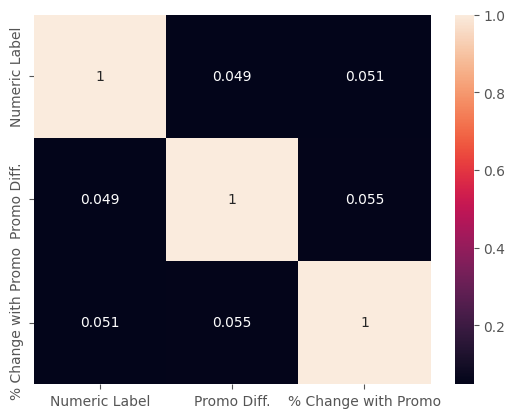

In [32]:
numeric_labels = {"Slow": 0, "Medium": 1, "Fast": 2}
promo_effect_by_store['Numeric Label'] = promo_effect_by_store['Label'].map(numeric_labels)
# plotting correlation heatmap 
dataplot = sns.heatmap(promo_effect_by_store[["Numeric Label", "Promo Diff.", "% Change with Promo"]].corr(), annot=True) 
plt.show() 

Promotion effects can be seen most clearly on fast products sold by medium stores.

## Forecasting

In [33]:
clusters_by_product = clusters_by_product.reset_index()
clusters_by_product.columns = ["ProductCode", "Sales-Stores Ratio", "Product Label"]
clusters_by_store = clusters_by_store.reset_index()
clusters_by_store.columns = ["StoreCode", "Sales-Products Ratio", "Store Label"]

In [34]:
train['dayofweek'] = train["Date"].dt.isocalendar()["day"]
test['dayofweek'] = test["Date"].dt.isocalendar()["day"]

train = train.merge(clusters_by_product, on='ProductCode', how='left')
train = train.merge(clusters_by_store, on='StoreCode', how='left')

test = test.merge(clusters_by_product, on='ProductCode', how='left')
test = test.merge(clusters_by_store, on='StoreCode', how='left')

categorical_features = ["ProductGroup1", "ProductGroup2", "Product Label", "Store Label"]
for feature in categorical_features:
    train[feature] = train[feature].astype("category")
    test[feature] = test[feature].astype("category")

train

,Date,StoreCode,ProductCode,SalesQuantity,IsPromoted,ProductGroup1,ProductGroup2,dayofweek,Sales-Stores Ratio,Product Label,Sales-Products Ratio,Store Label
0,2015-01-01,8,9,-1,False,H,15,4,0.072554,Slow,0.998368,Slow
1,2015-01-01,131,9,1,False,H,15,4,0.072554,Slow,1.594107,Medium
2,2015-01-01,144,9,2,False,H,15,4,0.072554,Slow,0.625725,Slow
3,2015-01-01,203,9,2,False,H,15,4,0.072554,Slow,0.554688,Slow
4,2015-01-01,256,9,0,False,H,15,4,0.072554,Slow,3.115750,Fast
...,...,...,...,...,...,...,...,...,...,...,...,...
1873613,2015-07-30,292,315,0,False,D,16,4,0.075651,Slow,0.896749,Slow
1873614,2015-07-31,12,315,1,False,D,16,5,0.075651,Slow,0.818705,Slow
1873615,2015-07-31,104,315,1,False,D,16,5,0.075651,Slow,1.625232,Medium
1873616,2015-07-31,261,315,1,False,D,16,5,0.075651,Slow,0.915527,Slow


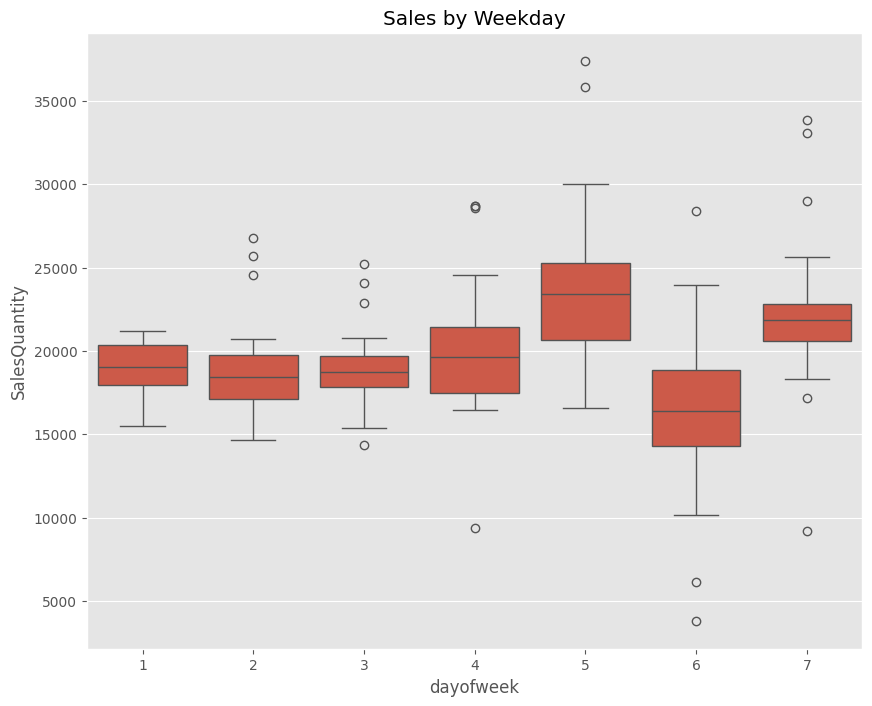

In [35]:
daily_aggregation = train.groupby(["Date"])['SalesQuantity'].sum()
daily_aggregation = pd.DataFrame(daily_aggregation).reset_index()
daily_aggregation['dayofweek'] = daily_aggregation["Date"].dt.isocalendar()["day"]

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=daily_aggregation, x='dayofweek', y='SalesQuantity')
ax.set_title('Sales by Weekday')
plt.show()

### Training

In [36]:
FEATURES = ['IsPromoted', 'ProductGroup1', 'ProductGroup2', 'dayofweek', 'Product Label', 'Store Label']
TARGET = ['SalesQuantity']

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [37]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       enable_categorical = True,
                       learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:5.31182	validation_1-rmse:4.93822
[100]	validation_0-rmse:4.76877	validation_1-rmse:4.43323
[200]	validation_0-rmse:4.67245	validation_1-rmse:4.36572
[300]	validation_0-rmse:4.64767	validation_1-rmse:4.35315
[400]	validation_0-rmse:4.63839	validation_1-rmse:4.34964
[500]	validation_0-rmse:4.63371	validation_1-rmse:4.34832
[600]	validation_0-rmse:4.63122	validation_1-rmse:4.34795
[700]	validation_0-rmse:4.62965	validation_1-rmse:4.34730
[800]	validation_0-rmse:4.62868	validation_1-rmse:4.34690
[900]	validation_0-rmse:4.62796	validation_1-rmse:4.34650
[999]	validation_0-rmse:4.62731	validation_1-rmse:4.34603


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

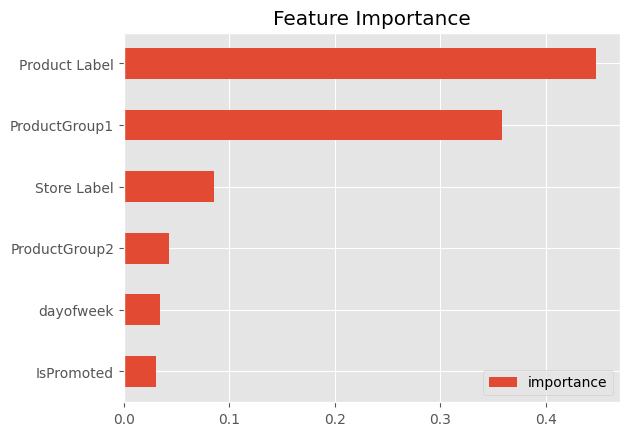

In [38]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [39]:
test['prediction'] = reg.predict(X_test)

train_helper = train
test_helper = test
train_helper = train_helper.groupby(["Date"])[['SalesQuantity']].sum()
test_helper = test_helper.groupby(["Date"])[['SalesQuantity', 'prediction']].sum()
train_helper = pd.concat([train_helper, pd.DataFrame(test_helper["SalesQuantity"])])

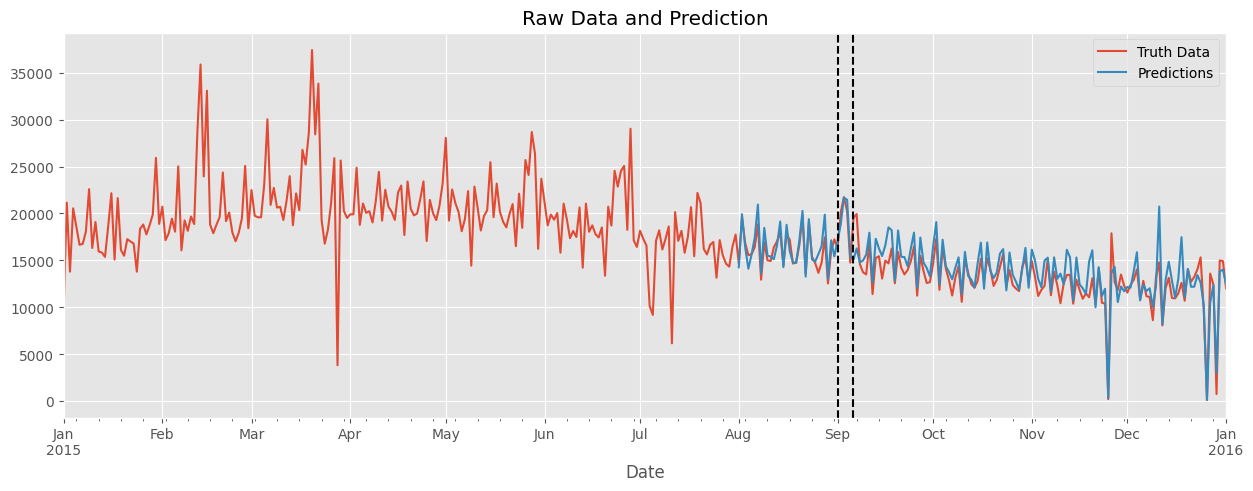

In [40]:
ax = train_helper.plot(figsize=(15, 5))
test_helper['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
ax.axvline(datetime(2015, 9, 1), color='black', ls='--')
ax.axvline(datetime(2015, 9, 6), color='black', ls='--')
plt.show()

In [41]:
score = np.sqrt(mean_squared_error(test['SalesQuantity'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 4.35


### Improvements

In [42]:
# External Data: USD Exchange Rates

usd_rates = pd.read_excel('EVDS_USD.xlsx')
usd_rates = usd_rates.fillna(method='ffill').fillna(method='bfill')
usd_rates["Tarih"] = pd.to_datetime(usd_rates["Tarih"], format="%d-%m-%Y")
usd_rates.columns = ["Date", "TL"]

train = train.merge(usd_rates, on='Date', how='left')
test = test.merge(usd_rates, on='Date', how='left')

In [43]:
# External Data: Official Holidays

holidays = [datetime(2015, 1, 1),   # Yılbaşı
            datetime(2015, 4, 23),  # 23 Nisan
            datetime(2015, 5, 1),   # 1 Mayıs
            datetime(2015, 5, 19),  # 19 Mayıs
            datetime(2015, 7, 16),  # Ramazan
            datetime(2015, 7, 17),  # Ramazan
            datetime(2015, 7, 18),  # Ramazan
            datetime(2015, 7, 19),  # Ramazan
            datetime(2015, 8, 30),  # 30 Ağustos
            datetime(2015, 9, 23),  # Kurban
            datetime(2015, 9, 24),  # Kurban
            datetime(2015, 9, 25),  # Kurban
            datetime(2015, 9, 26),  # Kurban
            datetime(2015, 9, 27),  # Kurban
            datetime(2015, 10, 28), # 29 Ekim
            datetime(2015, 10, 29), # 29 Ekim
            datetime(2015, 12, 31)] # Yılbaşı

holidays = {"Date": holidays, "IsHoliday": list(np.ones(len(holidays)))}
holidays = pd.DataFrame(holidays)

train = train.merge(holidays, on='Date', how='left')
train["IsHoliday"].fillna(0, inplace=True)
test = test.merge(holidays, on='Date', how='left')
test["IsHoliday"].fillna(0, inplace=True)

In [44]:
# Month and Quarter

train['month'] = train["Date"].dt.month
test['month'] = test["Date"].dt.month

train['quarter'] = train['Date'].dt.quarter
test['quarter'] = test['Date'].dt.quarter

<Axes: >

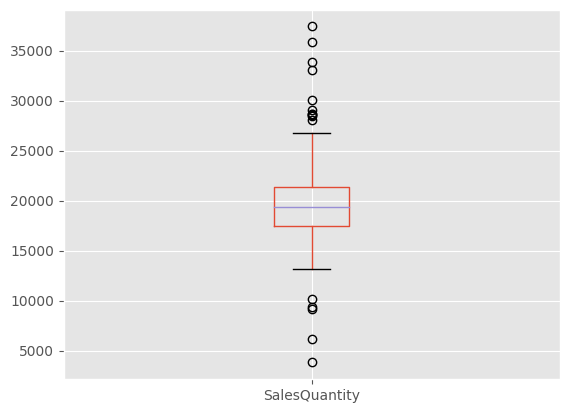

In [45]:
pd.DataFrame(daily_aggregation["SalesQuantity"]).boxplot()

In [46]:
# Outlier supression

too_much = daily_aggregation[daily_aggregation["SalesQuantity"] > 27500]["Date"]
too_few = daily_aggregation[daily_aggregation["SalesQuantity"] < 12000]["Date"]
too_much = pd.DataFrame(too_much)
too_much["High Outlier"] = 1
too_few = pd.DataFrame(too_few)
too_few["Low Outlier"] = 1

train = train.merge(too_much, on='Date', how='left')
train["High Outlier"].fillna(0, inplace=True)
train = train.merge(too_few, on='Date', how='left')
train["Low Outlier"].fillna(0, inplace=True)

test["High Outlier"] = 0
test["Low Outlier"] = 0

In [56]:
FEATURES = ['IsPromoted', 'ProductGroup1', 'ProductGroup2', 'dayofweek', 'Product Label', 'Store Label'
            ,'TL'
            ,'IsHoliday'
            ,'month', 'quarter'
            ,'High Outlier'
            ,'Low Outlier'
            ]
TARGET = ['SalesQuantity']

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [57]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       enable_categorical = True,
                       learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:5.31182	validation_1-rmse:4.93822
[100]	validation_0-rmse:4.76877	validation_1-rmse:4.43329
[200]	validation_0-rmse:4.67234	validation_1-rmse:4.36642
[300]	validation_0-rmse:4.64718	validation_1-rmse:4.35391
[400]	validation_0-rmse:4.63778	validation_1-rmse:4.35031
[500]	validation_0-rmse:4.63290	validation_1-rmse:4.34867
[600]	validation_0-rmse:4.63020	validation_1-rmse:4.34796
[700]	validation_0-rmse:4.62830	validation_1-rmse:4.34692
[800]	validation_0-rmse:4.62686	validation_1-rmse:4.34600
[900]	validation_0-rmse:4.62577	validation_1-rmse:4.34530
[999]	validation_0-rmse:4.62492	validation_1-rmse:4.34463


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

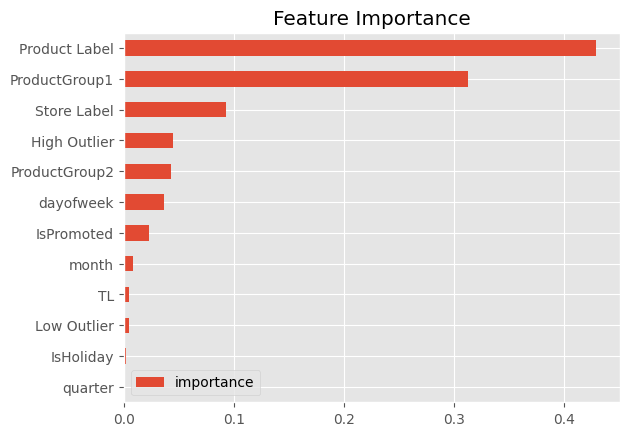

In [58]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [59]:
test['prediction'] = reg.predict(X_test)

train_helper = train
test_helper = test
train_helper = train_helper.groupby(["Date"])[['SalesQuantity']].sum()
test_helper = test_helper.groupby(["Date"])[['SalesQuantity', 'prediction']].sum()
train_helper = pd.concat([train_helper, pd.DataFrame(test_helper["SalesQuantity"])])

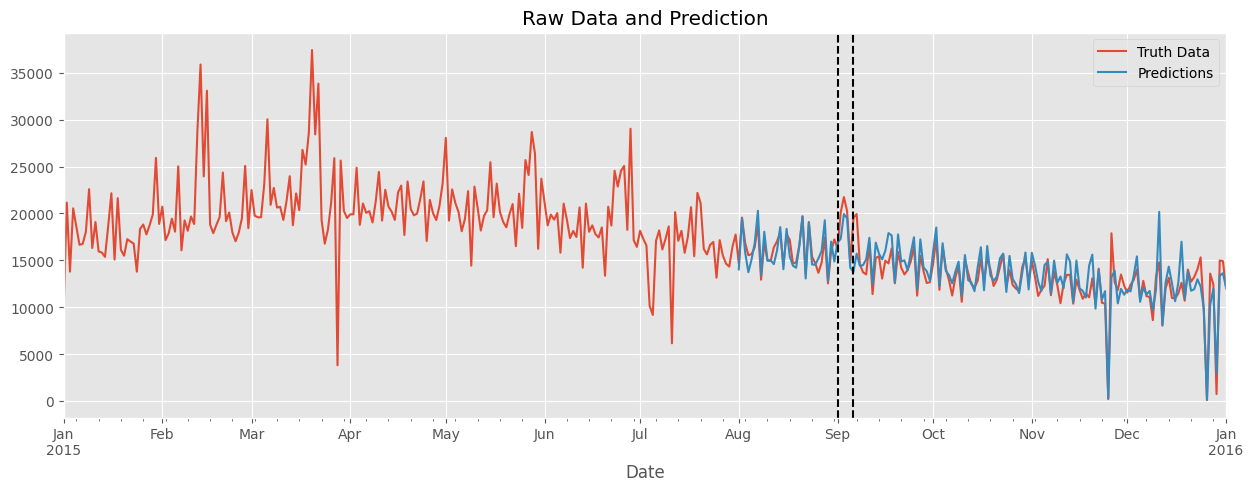

In [60]:
ax = train_helper.plot(figsize=(15, 5))
# helper["prediction"].mask(helper['prediction'] == 0, np.nan, inplace=True)
test_helper['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
ax.axvline(datetime(2015, 9, 1), color='black', ls='--')
ax.axvline(datetime(2015, 9, 6), color='black', ls='--')
plt.show()

In [61]:
score = np.sqrt(mean_squared_error(test['SalesQuantity'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 4.34
